In [1]:
# 전체 코드 예시: Pandas DataFrame에 저장된 데이터를 사용하여 GAN을 학습시키는 예제
"""
참조 : https://ddongwon.tistory.com/126
코드 : https://github.com/godeastone/GAN-torch/blob/main/models/Conditional%20GAN.py
"""
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
import time

import os
import random
import warnings
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 동일 결과 재생성을 위한 랜덤성 고정
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
print('Using device:', device)

Using device: cpu


### 전체 원재료코드(JRCODE) 및 공정종류(PUTGB) 인코딩 테이블 및 nast 딕셔너리 생성

In [3]:
combined_df = pd.read_csv(f'./final_dataset/combined_pps_data_fin.csv')
combined_df.head()

,ID,TYPE,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME,HS_VAL,SG_VAL,TS_VAL,EB_VAL
0,0000QY001_T010,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE017A,EE011G,EE023A,CB003A,CB001C,CB011B,CD023B,CD013A,CD011A,CD005A,FF005A,NN031A,OP004A,OP005A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.523810,27.619048,41.428571,2.380952,0.476190,0.476190,0.476190,0.714286,0.714286,0.714286,100.000000,54.285714,38.095238,19.047619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,74.0,1.100,151.0,245.0
1,0504PA001_T001,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,C1,CA019C,CA013A,CC022A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
2,0504PA001_T001,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
3,0504PA001_T002,LAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [4]:
tmp_df = combined_df.copy()
tmp_df = tmp_df.fillna(np.nan)

# 원재료 코드 리스트 생성
JRCODE_ls = []
jrcode_col_ls = [col for col in tmp_df.columns if 'JRCODE' in col]
for jrcode_col in jrcode_col_ls:
    JRCODE_ls += tmp_df[jrcode_col].unique().tolist()
    JRCODE_ls = list(set(JRCODE_ls))
    JRCODE_ls = [x for x in JRCODE_ls if str(x) != 'nan']

# 이상 원재료코드 리스트 생성
rm_jrcode_ls = [jr for jr in JRCODE_ls if 'C1' in jr]

for rm_jr in rm_jrcode_ls:
    JRCODE_ls.remove(rm_jr)

# 원재료 코드 테이블 생성
JRCODE_df = pd.DataFrame({'JRCODE':JRCODE_ls}).sort_values('JRCODE').reset_index(drop=True)
JRCODE_df['JR_ID'] = JRCODE_df.index
JRCODE_df = JRCODE_df[['JRCODE','JR_ID']]

# 공정 타입 테이블 생성 (1-6)
PUTGB_df = pd.DataFrame({'PUTGB':['P','CH','CB','OA','OB','F']}).reset_index(drop=True)
PUTGB_df['PUTGB_ID'] = PUTGB_df.index + 1 # (1-6)
PUTGB_df.columns = ['PUTGB_ID','PUTGB']

display(f'전체 원재료코드 수 : {len(JRCODE_df)}, 공정종류 수 : {len(PUTGB_df)}')

# 원재료 코드 dictionary 생성
JRCODE_dict = {}
for idx, row in JRCODE_df.iterrows():
    JRCODE_dict[row['JRCODE']] = row['JR_ID']

# 공정 타입 dictionary 생성
PUTGB_dict = {}
for idx, row in PUTGB_df.iterrows():
    PUTGB_dict[row['PUTGB']] = row['PUTGB_ID']

# nan을 마지막으로 추가
JRCODE_dict['0'] = len(JRCODE_dict)+1
PUTGB_dict['0'] = len(PUTGB_dict)+1

display(f'NAN포함!! JRCODE 딕셔너리 길이: {len(JRCODE_dict)}, PUTGB 딕셔너리 길이: {len(PUTGB_dict)}')

'전체 원재료코드 수 : 833, 공정종류 수 : 6'

'NAN포함!! JRCODE 딕셔너리 길이: 834, PUTGB 딕셔너리 길이: 7'

In [5]:
filtered_idx_ls = []
for rm_jrcode in rm_jrcode_ls:
    for col in jrcode_col_ls:
        tmp_tmp_df = tmp_df[~(tmp_df[col].isna())]
        filtered_idx_ls += tmp_tmp_df[(tmp_tmp_df[col].str.contains(rm_jrcode))].index.tolist()

        filtered_idx_ls = list(set(filtered_idx_ls))

tmp_df = tmp_df.iloc[[idx for idx in tmp_df.index if idx not in filtered_idx_ls]].reset_index(drop=True)
tmp_df = tmp_df.fillna(0)
tmp_df

,ID,TYPE,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME,HS_VAL,SG_VAL,TS_VAL,EB_VAL
0,0000QY001_T010,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE017A,EE011G,EE023A,CB003A,CB001C,CB011B,CD023B,CD013A,CD011A,CD005A,FF005A,NN031A,OP004A,OP005A,0,0,0,0,0,0,0,0,0,0,0,9.523810,27.619048,41.428571,2.380952,0.47619,0.47619,0.47619,0.714286,0.714286,0.714286,100.000,54.285714,38.095238,19.047619,0.000,0.000,0.000,0.000000,0.000,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,74.0,1.100,151.0,245.0
1,0504PA001_T001,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
2,0504PA001_T002,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100.000000,10.000000,1.000000,2.000000,10.00000,15.00000,15.00000,0.000000,0.000000,0.000000,

In [6]:
# Discriminator 모델 정의
class Discriminator(nn.Module):
    def __init__(self, input_size, condition_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)

# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self, input_size, output_size, condition_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, 128),
            nn.LeakyReLU(),
            # nn.BatchNorm1d(256),
            nn.Linear(128, 32),
            nn.LeakyReLU(),
            # nn.BatchNorm1d(64),
            nn.Linear(32, 128),
            nn.LeakyReLU(),
            # nn.BatchNorm1d(64),
            nn.Linear(128, output_size),
        )
    
    def forward(self, x):
        return self.model(x)
    
# For checking CGAN's validity in final step
def check_condition(_generator, sample_num, target_labels, condition_size_ls, latent_size):

    for i in np.arange(len(target_labels)):
        test_label = torch.full((1, sample_num), target_labels[i]).squeeze(0)    
        if i == 0:            
            test_label_encoded = F.one_hot(test_label, num_classes=condition_size_ls[i]).to(device)
        else:
            test_label_encoded = torch.cat((test_label_encoded, F.one_hot(test_label, num_classes=condition_size_ls[i]).to(device)), 1)

    # create noise(latent vector) 'z'
    _z = torch.randn(sample_num, latent_size).to(device)
    _z_concat = torch.cat((_z, test_label_encoded), 1)
    generated_data = _generator(_z_concat)

    return generated_data.detach()

In [31]:
batch_size = 64
lr = 0.001
num_epochs = 100
show_step = 10
latent_size_ = 100

stVal = 0

criterion = nn.BCELoss()

# 대상
trg_yCols = ['HS_VAL','SG_VAL','TS_VAL','EB_VAL']

grNum_ls = []

for yCol in trg_yCols:
    nUniq = data_df[yCol].nunique()
    if nUniq < 100:
        grNum = nUniq//5
    else:
        grNum = min(50, nUniq//10)
    
    # print(f'groupNum : {grNum}')
    data_df[yCol+'_G'], cutBins = pd.qcut(data_df[yCol],grNum, labels=np.arange(stVal,stVal+grNum), retbins=True)
    grNum_ls.append(grNum)

# 필요없는 변수 제거 (그룹화한 결과는 존재)
data_df = data_df.drop(['ID','TYPE'] + trg_yCols, axis=1)
# batch_size 로 나눠지도록 나머지 버림
data_df = data_df.iloc[:-(len(data_df) % batch_size)]

# DataFrame을 PyTorch Tensor로 변환
data = torch.tensor(data_df.values, dtype=torch.float32)

# DataLoader 설정
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델, 옵티마이저, 손실 함수 설정
condition_size = sum(grNum_ls)                              # 조건 feature의 개수
input_size = len(data_df.columns) - len(trg_yCols)          # 입력 feature의 개수
output_size = input_size                                    # 출력 feature의 개수 (입력과 동일하게)
latent_size = latent_size_                                  # 잠재 공간의 크기

discriminator = Discriminator(input_size, condition_size)
generator = Generator(latent_size, output_size, condition_size)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

p_d_real_trace = []
p_d_gen_trace = []
p_g_gen_trace = []

# 학습 시작
stTime = time.time()

gen_loss_trace = []
dis_loss_trace = []

for epoch in range(num_epochs):

    gen_loss = 0
    dis_loss = 0

    for n, (real_data,) in enumerate(dataloader):
        # batch_size = real_samples.size(0)

        real_data_labels = torch.ones((batch_size, 1))
        fake_data_labels = torch.zeros((batch_size, 1))

        x = real_data[:,:-len(trg_yCols)]
        labels = real_data[:,-len(trg_yCols):]

        """
        FOR CONDITIONAL GAN
        """
        for i in np.arange(len(trg_yCols)):
            # Encode label with 'one hot encoding'
            if i == 0:
                label_encoded = F.one_hot(labels[:,i].to(torch.int64), num_classes=grNum_ls[i]).squeeze(1)
            else:
                label_encoded = torch.cat((label_encoded, F.one_hot(labels[:,i].to(torch.int64), num_classes=grNum_ls[i]).squeeze(1)), 1)

        # concat real images with 'label encoded vector'
        real_data_concat = torch.cat((x, label_encoded), 1)

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # Initialize grad
        g_optimizer.zero_grad()
        d_optimizer.zero_grad()

        # make fake data with generator & noise vector 'z'
        z = torch.randn(batch_size, latent_size)

        """
        FOR CONDITIONAL GAN
        """
        # concat noise vector z with encoded labels
        z_concat = torch.cat((z, label_encoded), 1)
        fake_data = generator(z_concat)
        fake_data_concat = torch.cat((fake_data, label_encoded), 1)

        # Compare result of discriminator with fake images & real labels
        # If generator deceives discriminator, g_loss will decrease
        g_loss = criterion(discriminator(fake_data_concat), real_data_labels)

        # Train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        gen_loss += g_loss.item()/batch_size

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # Initialize grad
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()

        # make fake images with generator & noise vector 'z'
        z = torch.randn(batch_size, latent_size)

        """
        FOR CONDITIONAL GAN
        """
        # concat noise vector z with encoded labels
        z_concat = torch.cat((z, label_encoded), 1)
        fake_data = generator(z_concat)
        fake_data_concat = torch.cat((fake_data, label_encoded), 1)

        # Calculate fake & real loss with generated images above & real images
        fake_loss = criterion(discriminator(fake_data_concat), fake_data_labels)
        real_loss = criterion(discriminator(real_data_concat), real_data_labels)
        d_loss = (fake_loss + real_loss) / 2

        # Train discriminator with backpropagation
        # In this part, we don't train generator
        d_loss.backward()
        d_optimizer.step()

        dis_loss += d_loss.item()/batch_size

        # d_performance = discriminator(real_data_concat).mean()
        # g_performance = discriminator(fake_data_concat).mean()

        p_d_real_trace.append(real_loss.item())
        p_d_gen_trace.append(fake_loss.item())
        p_g_gen_trace.append(g_loss.item())

    # Show loss
    if epoch % show_step == 0:
        print(f"Epoch: {epoch:3.0f} Loss D.: {dis_loss:.5f}, Loss G.: {gen_loss:.5f}, time: {(time.time() - stTime):.3f}s")
        stTime = time.time()

    gen_loss_trace.append(gen_loss)
    dis_loss_trace.append(dis_loss)

Epoch:   0 Loss D.: 2.51536, Loss G.: 8.79734, time: 6.130s
Epoch:  10 Loss D.: 0.40594, Loss G.: 46.95601, time: 58.382s
Epoch:  20 Loss D.: 0.85420, Loss G.: 35.92093, time: 58.922s
Epoch:  30 Loss D.: 1.40552, Loss G.: 26.14747, time: 57.932s
Epoch:  40 Loss D.: 2.18747, Loss G.: 18.84720, time: 59.193s
Epoch:  50 Loss D.: 2.62977, Loss G.: 15.84486, time: 60.082s
Epoch:  60 Loss D.: 2.77499, Loss G.: 14.70111, time: 58.755s
Epoch:  70 Loss D.: 2.94625, Loss G.: 13.44392, time: 58.032s
Epoch:  80 Loss D.: 3.08055, Loss G.: 13.11886, time: 57.391s
Epoch:  90 Loss D.: 2.93040, Loss G.: 14.96587, time: 56.458s


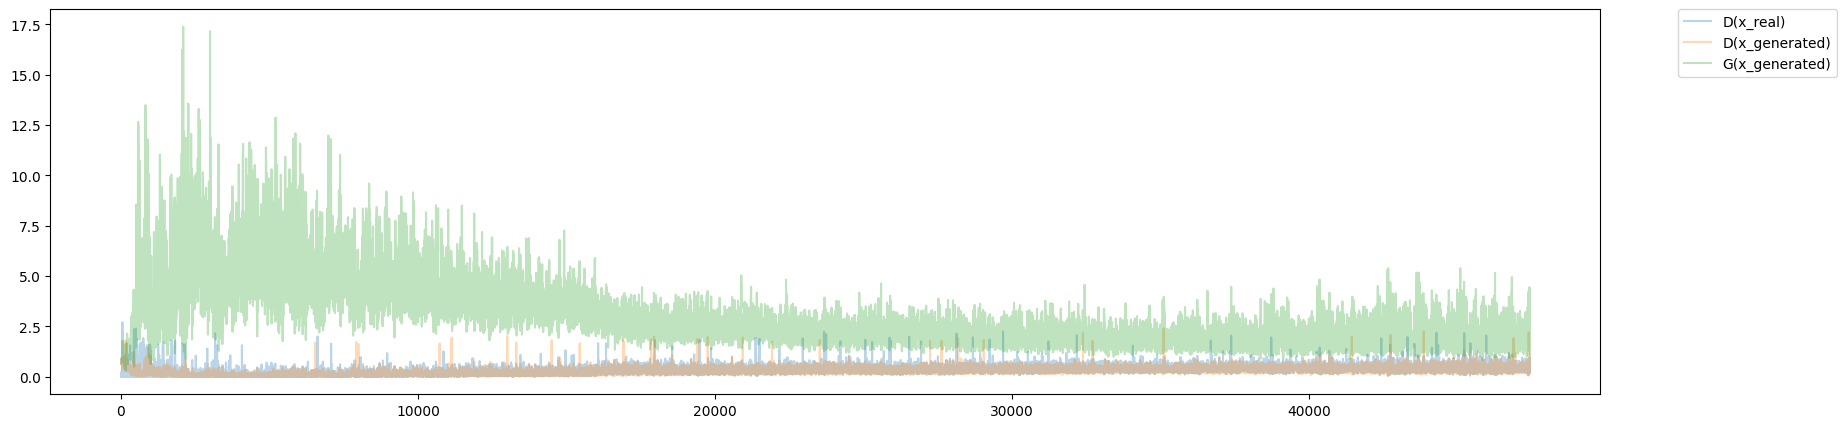

In [32]:
from matplotlib import pyplot as plt

sIdx = 50
plt.figure(figsize=(20,5))
plt.plot(p_d_real_trace[sIdx:], label='D(x_real)', alpha=0.3)
plt.plot(p_d_gen_trace[sIdx:], label='D(x_generated)', alpha=0.3)
plt.plot(p_g_gen_trace[sIdx:], label='G(x_generated)', alpha=0.3)
# plt.ylim(0,5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

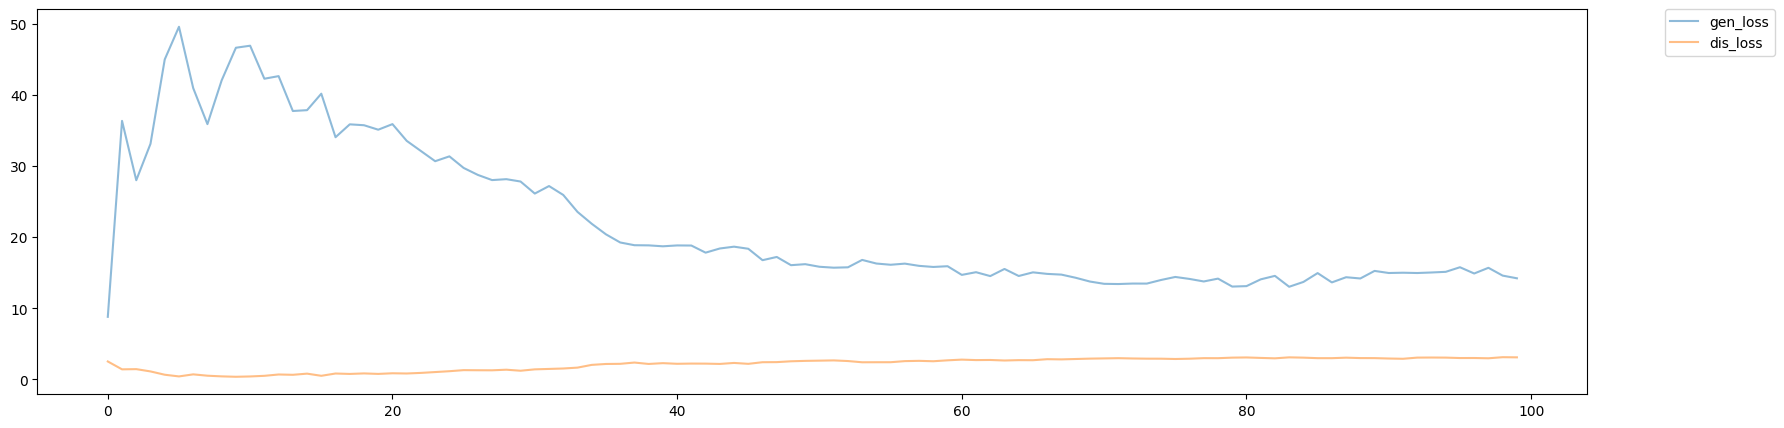

In [33]:
from matplotlib import pyplot as plt

sIdx = 0
plt.figure(figsize=(20,5))
plt.plot(gen_loss_trace[sIdx:], label='gen_loss', alpha=0.5)
plt.plot(dis_loss_trace[sIdx:], label='dis_loss', alpha=0.5)
# plt.ylim(0,2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [34]:
trg_label_ls = [1, 1, 1, 1]

check_df = data_df[(data_df[trg_yCols[0]+'_G']==trg_label_ls[0])|(data_df[trg_yCols[1]+'_G']==trg_label_ls[1])
                   |(data_df[trg_yCols[2]+'_G']==trg_label_ls[2])|(data_df[trg_yCols[3]+'_G']==trg_label_ls[3])]

n_samples = len(check_df)
gen_samples = check_condition(generator, n_samples, trg_label_ls, grNum_ls, latent_size).detach().numpy()

gen_df = pd.DataFrame(gen_samples, columns=data_df.columns[:-len(trg_label_ls)])
# display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
display('ori:',check_df.describe(),'gen:',gen_df.describe())

'ori:'

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
count,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.00000,4113.000000,4113.000000,4113.00000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.0,4113.0,4113.0,4113.0,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000
mean,103.771721,107.639146,106.943734,108.114382,105.292538,105.848720,75.192280,74.792703,73.757416,89.603684,93.326976,144.884621,376.540530,542.581528,698.718940,786.986628,782.699003,785.468271,525.259908,276.110139,27.558473,6.416727,0.471918,79.062005,59.238189,59.607534,64.467305,82.840877,93.877866,111.845430,113.118593,112.352370,112.372566,100.448486,76.048335,54.747358,45.073487,34.722505,35.313395,37.013008,29.950644,13.043788,7.223049,1.141746,0.183613,0.019718,70.107681,21.282190,22.693641,26.868062,27.130076,17.444451,27.214425,22.263754,21.818428,22.175697,22.901724,18.218086,18.444299,11.27750,14.507604,16.694797,25.51984,15.975954,11.293095,4.802358,0.143010,0.008510,0.0,174.868760,43.185922,43.953544,56.692925,61.037941,39.905899,60.286239,54

'gen:'

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
count,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000
mean,23.302908,25.692404,26.008993,29.515108,18.083035,27.152071,28.558418,22.221527,25.477762,26.578251,14.412642,1.957337,0.974318,-1.766444,0.091929,-0.653771,-2.173504,-1.118544,-3.191388,-4.934473,-2.419710,-0.470165,-3.671306,49.766167,42.921730,43.858170,48.880486,50.375858,54.940765,72.940216,73.612648,86.346657,81.856384,67.448410,44.129848,12.350107,6.733285,15.663679,15.458783,15.516226,5.911972,3.716803,4.143054,7.526680,4.598215,-0.908340,51.276920,8.535491,20.392246,15.825897,11.131899,13.155511,13.511600,11.687018,11.390565,18.059704,13.502285,6.042589,8.254930,12.169887,5.441573,9.703529,5.193434,-0.243979,-2.545695,0.692962,-4.356411,-1.966379,-1.123577,108.368057,22.530748,36.258007,39.422943